In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from src.Simulator.SSA import SSASimulator
import numpy as np

2023-08-23 09:42:42.747763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 09:42:42.827343: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 09:42:42.828267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 09:42:44.372222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [6]:
from src.Models.models import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
y, t = simulator_bd.run_ssa(np.array([5]), 10000, parameters)
num_states = y.shape[1]

We set up the NN model

In [16]:
from src.Models.utils import getReactionsForObservations
from src.Estimation.NN import CTMCModel

reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

Model = tf.keras.models.Sequential([
    tf.keras.layers.Input((num_states,)),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(num_unique_stoch, activation=tf.keras.activations.softplus)
])

custom_model = CTMCModel(Model)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_model.compile(optimizer)

times_spent = t[1:] - t[:-1]
# tf.config.experimental_run_functions_eagerly(True)
train_dataset = tf.data.Dataset.from_tensor_slices((y[:-1], times_spent, reaction_indices)).batch(256)

We train the model on the training data

In [17]:
custom_model.fit(train_dataset, epochs=10)

Epoch 1/10
78/78 [==============================] - 5s 50ms/step - loss: 264.3337
Epoch 2/10
78/78 [==============================] - 4s 47ms/step - loss: 253.8827
Epoch 3/10
78/78 [==============================] - 4s 46ms/step - loss: 253.6733
Epoch 4/10
78/78 [==============================] - 4s 46ms/step - loss: 253.7468
Epoch 5/10
78/78 [==============================] - 4s 47ms/step - loss: 253.4780
Epoch 6/10
78/78 [==============================] - 3s 42ms/step - loss: 253.3648
Epoch 7/10
78/78 [==============================] - 4s 45ms/step - loss: 252.3944
Epoch 8/10
78/78 [==============================] - 4s 46ms/step - loss: 252.0807
Epoch 9/10
78/78 [==============================] - 4s 51ms/step - loss: 252.0020
Epoch 10/10
78/78 [==============================] - 4s 47ms/step - loss: 251.9084


We plot the estimation results

624/624 [==============================] - 1s 1ms/step
Mean Squared Error between NN predictions and expected propensities: 0.004293536463702274


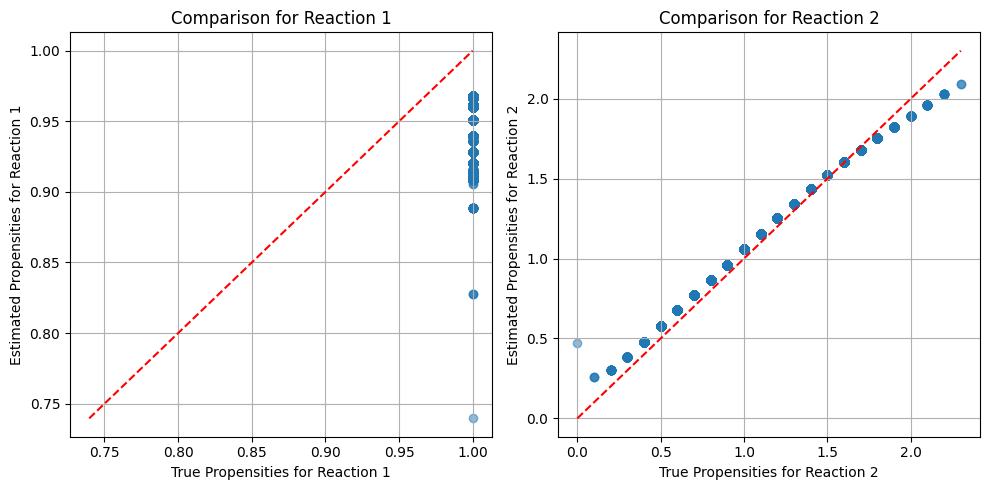

In [18]:
from src.Estimation.utils import createPropensityPlot
nn_predictions = custom_model.predict(y)

# get true propensities
true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
    
true_props_unique

comparison = nn_predictions - true_props_unique

mse = np.mean(np.square(comparison))
print(f"Mean Squared Error between NN predictions and expected propensities: {mse}")

fig = createPropensityPlot(nn_predictions, true_props_unique)

Lets compare it with the MLE 

/tmp/ipykernel_25634/1519838007.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


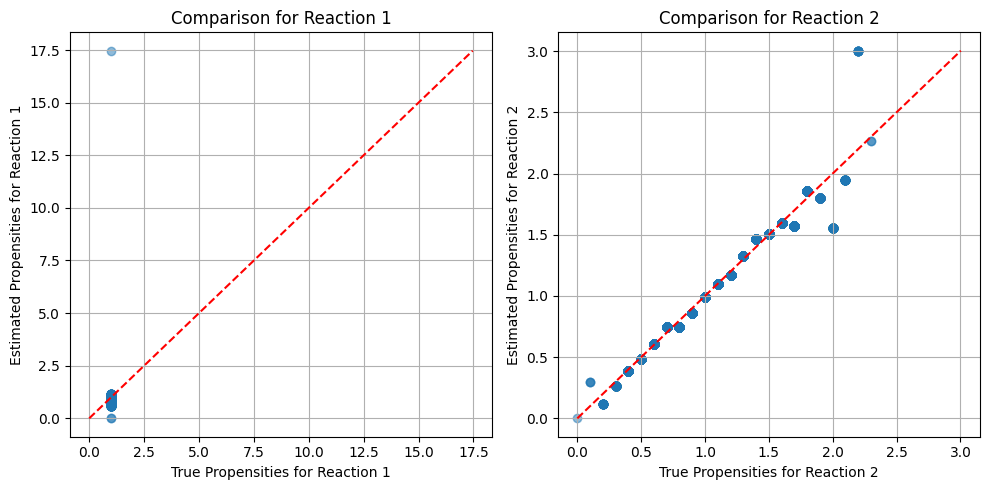

In [15]:
from src.Estimation.MLE import MLEstimator
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()